# Событийная аналитика для стартапа, продающего продукты питания. Анализ А/А/В-теста.
***

# Описание проекта

Нужно проанализирвоать поведение пользователей мобильного приложения стартапа, продающего продукты. Исследовать результаты A/A/B-эксперимента замены шрифта в приложении.

#### Описание данных для исследования

Для анализа представылены логи со следующими колонками:
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Оглавление<a class='anchor' id='TOC'></a>

* **[I. Подготовка к анализу](#1)**
* **[2. Исследовательский анализ данных](#2)**
    - [1) Общие сведения о событиях и пользователях](#2_1)
    - [2) Проверим период логирования](#2_2)
* **[3. Анализ поведения пользователей](#3)**
    - [1) Общие сведения о поведении пользователей](#3_1)
    - [2) Воронка событий](#3_2)
* **[4. Анализ A/A/B-теста](#4)**
    - [1) Проверим корректность разбиения групп](#4_1)
    - [2) Проведем статистические тесты для контрольных групп](#4_2)
    - [3) Проведем статистические тесты для тестовой группы](#4_3)
* **[Выводы](#conclusions)**
<br></br>

# I. Подготовка к анализу<a class='anchor' id='1'></a>

## 1) Импортируем библиотеки, объявим класс и несколько полезных функций для анализа данных<a class="anchor" id="1_1"></a>

Импортируем библиотеки:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from solver.data_reader import DataReader, get_profiles, simple_grouper
from solver.graphs import funnel_plot, histogram
from solver.stat_tests import StatTest, get_intersections, report_styler

[В оглавление](#TOC)

## 2) Прочитаем данные<a class="anchor" id="1_2"></a>

### - инициализируем класс

In [2]:
reader = DataReader('logs_exp.csv')

### - выведем первые пять первых и последних строк таблицы , общую информацию, статиcтику

In [3]:
reader.basic_info_printer(reader.origin_data)

'Пять первых и последних строк'

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


'Общая информация о датасете'

,Column,Dtype,Non-Null Count,% of nulls
0,EventName,object,244126,0.0
1,DeviceIDHash,int64,244126,0.0
2,EventTimestamp,int64,244126,0.0
3,ExpId,int64,244126,0.0


'Описательная статистика'

,count,unique,top,freq,% of tops freq
EventName,244126,5,MainScreenAppear,119205,48.83


&#9889; **Выводы**

1. В представленных данных 244126 наблюдений, без явных пропусков, без явных проблем с типом данных.
2. Судя по формату в столбце "EventTimestamp" - время события записано в формате [Unix-времени](https://ru.wikipedia.org/wiki/Unix-%D0%B2%D1%80%D0%B5%D0%BC%D1%8F), то есть в секундах (для минут указывают дополнительнео minutes, для наносекунд ns).
3. Всего представленны данные о пяти различных события, самое частое из которых - загрузка заглавной страницы (119 205 из 244 126 наблюдений, 49%).
4. Потребуется пересчитать дату - получить столбец с датой и временем в формате ISO и столбец только с датой.
5. Кроме того, переименуем для ясности колонки, события, группы.

### - пересчитаем дату события, создадим столбцы с полным временем и, отдельно, датой, переименуем колонки, события и группы

In [4]:
logs = reader.data_cleaner()
logs

,event,id,origin_timestamp,group,timestamp,date
0,main screen,4575588528974610257,1564029816,A_one,2019-07-25 04:43:36,2019-07-25
1,main screen,7416695313311560658,1564053102,A_one,2019-07-25 11:11:42,2019-07-25
2,payment,3518123091307005509,1564054127,B_test,2019-07-25 11:28:47,2019-07-25
3,cart,3518123091307005509,1564054127,B_test,2019-07-25 11:28:47,2019-07-25
4,payment,6217807653094995999,1564055322,B_test,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,main screen,4599628364049201812,1565212345,A_two,2019-08-07 21:12:25,2019-08-07
244122,main screen,5849806612437486590,1565212439,A_one,2019-08-07 21:13:59,2019-08-07
244123,main screen,5746969938801999050,1565212483,A_one,2019-08-07 21:14:43,2019-08-07
244124,main screen,5746969938801999050,1565212498,A_one,2019-08-07 21:14:58,2019-08-07


Получили таблицу с шестью столбцами, 244 126 строками. Наименования столбцов:
- events - события,
- user_id - хэш пользователя,
- origin_timestamp - оригинальная информация о времени события,
- group - сведения о группе,
- timestamp - пересчитанная дата и время,
- date - дата события.

### - выведем первые пять первых и последних строк полученной таблицы, общую информацию, статиcтику результата

In [5]:
reader.basic_info_printer(logs)

'Пять первых и последних строк'

,event,id,origin_timestamp,group,timestamp,date
0,main screen,4575588528974610257,1564029816,A_one,2019-07-25 04:43:36,2019-07-25
1,main screen,7416695313311560658,1564053102,A_one,2019-07-25 11:11:42,2019-07-25
2,payment,3518123091307005509,1564054127,B_test,2019-07-25 11:28:47,2019-07-25
3,cart,3518123091307005509,1564054127,B_test,2019-07-25 11:28:47,2019-07-25
4,payment,6217807653094995999,1564055322,B_test,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,main screen,4599628364049201812,1565212345,A_two,2019-08-07 21:12:25,2019-08-07
244122,main screen,5849806612437486590,1565212439,A_one,2019-08-07 21:13:59,2019-08-07
244123,main screen,5746969938801999050,1565212483,A_one,2019-08-07 21:14:43,2019-08-07
244124,main screen,5746969938801999050,1565212498,A_one,2019-08-07 21:14:58,2019-08-07


'Общая информация о датасете'

,Column,Dtype,Non-Null Count,% of nulls
0,event,object,244126,0.0
1,id,int64,244126,0.0
2,origin_timestamp,int64,244126,0.0
3,group,object,244126,0.0
4,timestamp,datetime64[ns],244126,0.0
5,date,object,244126,0.0


'Описательная статистика'

,count,unique,top,freq,% of tops freq,first,last
timestamp,244126,176654,2019-08-01 14:40:35,9,0.00,2019-07-25 04:43:36,2019-08-07 21:15:17
date,244126,14,2019-08-01,36229,14.84,---,---
group,244126,3,B_test,85747,35.12,---,---
event,244126,5,main screen,119205,48.83,---,---


### - посчитаем количество дубликатов

In [6]:
logs.duplicated().sum()

413

### - исключим дубликаты

Поскольку выявленны именно полные дубликаты - принимая во внимание, что в том числе это дубликаты по полной дате - в отстутвии возможности уточнить у поставщика данных природу возникновения дубликатов, учитывая что 413 наблдений составляют менее 1% от наблюдений: принято решение исключить их из исследования на стадии подготовки, предварительно сохранив копию.

In [7]:
duplicates = logs[logs.duplicated()].copy()

In [8]:
logs.drop_duplicates(inplace=True)
logs

,event,id,origin_timestamp,group,timestamp,date
0,main screen,4575588528974610257,1564029816,A_one,2019-07-25 04:43:36,2019-07-25
1,main screen,7416695313311560658,1564053102,A_one,2019-07-25 11:11:42,2019-07-25
2,payment,3518123091307005509,1564054127,B_test,2019-07-25 11:28:47,2019-07-25
3,cart,3518123091307005509,1564054127,B_test,2019-07-25 11:28:47,2019-07-25
4,payment,6217807653094995999,1564055322,B_test,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,main screen,4599628364049201812,1565212345,A_two,2019-08-07 21:12:25,2019-08-07
244122,main screen,5849806612437486590,1565212439,A_one,2019-08-07 21:13:59,2019-08-07
244123,main screen,5746969938801999050,1565212483,A_one,2019-08-07 21:14:43,2019-08-07
244124,main screen,5746969938801999050,1565212498,A_one,2019-08-07 21:14:58,2019-08-07


### - проверим последовательно ли идут события

Убедимся в том, что события представлены последовательно во времени, поскольку это критично для целей анализа -в том числе с целью определения последовательности взаимодействия с приложением:

In [9]:
logs['timestamp'].is_monotonic

True

&#9889; **Выводы**

1. В представленных данных наблюдения за две недели: от 25 июля 2019 года до 07.08.2019 года. Данные идут последовательно.
2. Больше всего наблюдений от 01 августе 2019 года (36 299 из 244 126, 15%).
3. Больше всего наблюдений о тестовой группе В - 35% (85 747). Требуется дополнительно проверить разбиение групп.
4. В данных обнаружено 413 полных дубликатов, принято решение об исключении дубликатов на стадии подготовки: получен датасет в 243 713 строк и 6 колонок.

[В оглавление](#TOC)

# II. Исследовательский анализ данных<a class='anchor' id='2'></a>

## 1) Общие сведения о событиях и пользователях <a class="anchor" id="2_1"></a>

### - cколько всего событий и пользователей в логе

In [10]:
# Группируем данные по событиям, считаем уникальных пользователей
events_and_users = logs.groupby('event', as_index=False).agg({'id': 'nunique'})

# Считаем общее число уникальных пользователей
events_and_users['total_users'] = logs['id'].nunique()

# Считаем долю пользователей для каждого события
events_and_users['percent'] = round(events_and_users['id'] * 100 / 
                                    events_and_users['total_users'], 2)

# Переименовываем и сортируем результат
events_and_users.rename(columns={'id': 'unique_users'}, inplace=True)
events_and_users.sort_values(by='percent', ascending=False)

,event,unique_users,total_users,percent
1,main screen,7439,7551,98.52
2,offer screen,4613,7551,61.09
0,cart,3749,7551,49.65
3,payment,3547,7551,46.97
4,tutorial,847,7551,11.22


&#9889; **Выводы**

1. В представленном датасете 243 713 наблюдений о 7 551 уникальном пользователе.
2. Всего в датасете представлено пять событий:
    - main screen (посетило 7 439 уникальных пользователей из 7 551, 98.47%)
    - offer screen (посетило 4613 уникальных пользователей из 7 551, 60.96%)
    - cart (посетило 3749 уникальных пользователей из 7 551, 49.56%)
    - payment (посетило 3547 уникальных пользователей из 7 551, 46.97%)
    - tutorial (посетило 847 уникальных пользователей из 7 551, 11.15%)


3. В целом, почти половина из тех, кто пришел - что-то купили.

### - cколько в среднем событий приходится на пользователя

Чтобы посчитать сколько в среднем событый приходится на пользователя воспользуемся группировкой:

In [11]:
# Посчитам сколько из каждого вида событый у каждого пользоватлей
count_events = logs.groupby(['event', 'id'],
                            as_index=False).agg({'date': 'count'})

# Сгруппируем результат по событию и посчитаем среднее
mean_events = count_events.groupby(
    'event', as_index=False).agg({'date': 'mean'})

# Переименуем колонку со средним
mean_events.rename(columns={'date': 'mean_per_user'}, inplace=True)

# Отсортируем результат
mean_events.sort_values(by='mean_per_user', ascending=False, inplace=True)

# Добавим среднее на пользователя по событяим в совокупности
result_row = pd.Series(['All events',
                        len(logs) / logs['id'].nunique()],
                       index=mean_events.columns)
mean_events = mean_events.append(result_row, ignore_index=True)

mean_events

,event,mean_per_user
0,main screen,16.010351
1,cart,11.381168
2,offer screen,10.146976
3,payment,9.618833
4,tutorial,1.201889
5,All events,32.275593


&#9889; **Выводы**

1. В среднем, на пользователя приходится 32.27 событий.
2. Из пяти событий в представленных данных на пользователя, в среднем, приходится:
    - 16 посещений главного экрана,
    - 11.38 посещений корзины,
    - 10.14 посещенйй страницы с предложениями,
    - 9.6 платежей,
    - 1.2 обучение
3. Как следствие, средний пользователь один раз проходит обучение, но зато потом почти десять раз купит что-то.

[В оглавление](#TOC)

## 2) Сведения о периоде логирования <a class="anchor" id="2_2"></a>

### - период логирования, максимальная и минимальные даты записи

In [12]:
reader.get_describe(logs)

,count,unique,top,freq,% of tops freq,first,last
timestamp,243713,176654,2019-08-01 14:40:35,9,0.00,2019-07-25 04:43:36,2019-08-07 21:15:17
date,243713,14,2019-08-01,36141,14.83,---,---
group,243713,3,B_test,85582,35.12,---,---
event,243713,5,main screen,119101,48.87,---,---


Период логирования - с 25.07.2019 до 07.08.2019 года, две недели.


### - построим гистограмму по дате и времени

Подготовим подписи для графика:

In [13]:
labels = {'xlabel': 'Дата наблюдений',
          'title': 'Наблюдения из логов по дате и времени'}

Построим гистограмму:

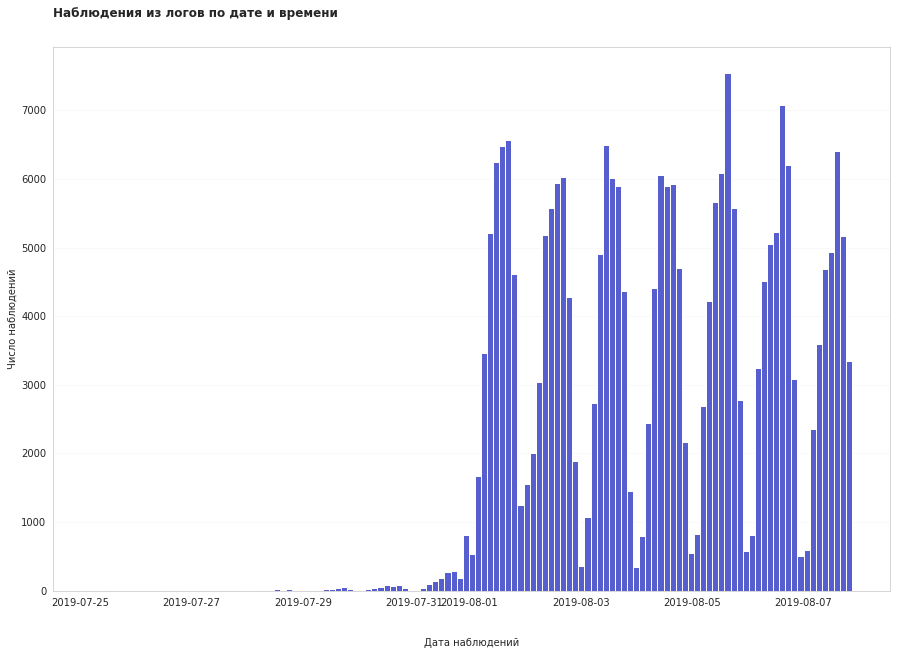

In [14]:
histogram(logs.timestamp, labels=labels)

Исходя из гистограммы можно сделать вывод о том, что данных за июль, фактически, нет - наблюдений сравнительно мало. Кроме того, у нас мультимодальное распределние - принимая во внимание наличие семи выраженных пиков с провалами, с некоторой осторожностью, можно предположить, что во временном ряде наблюдаются дневные циклы.

### - оценим полноту данных

Сгруппируем данные по дате и посчитаем количество наблюдений по каждому дню:

In [15]:
grouped_by_date = simple_grouper(logs, 'date')
grouped_by_date

,date,id,percent
7,2019-08-01,36141,14.83
11,2019-08-05,36058,14.80
12,2019-08-06,35788,14.68
8,2019-08-02,35554,14.59
9,2019-08-03,33282,13.66
10,2019-08-04,32968,13.53
13,2019-08-07,31096,12.76
6,2019-07-31,2030,0.83
5,2019-07-30,412,0.17
4,2019-07-29,184,0.08


Табличные данные подтверждают относительную малочисленность данных за июль замеченные на гистограмме: за период от 25.07.2019 года до 31.07.2019 года зафиксировано чуть более 1% всех наблюдений о пользователях. Посчитаем сколько наблюдений попало в период от 25 до 31 июля:

In [16]:
grouped_by_date.query('percent < 1').sum()

id         2826.00
percent       1.15
dtype: float64

Всего 2826 из 243 713 наблюдений, 1.15%, попали в период от 25 до 31 июля. Для целей анализа, принимая во внимание малочисленность наблюдений за этот период, данные за указанный период можно исключить.

### - исключим неполные логи

Сохраним также логи за июль: это повод обратиться к поставщику данных, возможно, стоит проверить правильно ли ведутся ли логи.

In [17]:
july_logs = logs.query('timestamp < "2019-08-01"').copy()
july_logs

,event,id,origin_timestamp,group,timestamp,date
0,main screen,4575588528974610257,1564029816,A_one,2019-07-25 04:43:36,2019-07-25
1,main screen,7416695313311560658,1564053102,A_one,2019-07-25 11:11:42,2019-07-25
2,payment,3518123091307005509,1564054127,B_test,2019-07-25 11:28:47,2019-07-25
3,cart,3518123091307005509,1564054127,B_test,2019-07-25 11:28:47,2019-07-25
4,payment,6217807653094995999,1564055322,B_test,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
2823,offer screen,2413191300976302222,1564617295,A_two,2019-07-31 23:54:55,2019-07-31
2824,main screen,5505110279185484837,1564617450,A_two,2019-07-31 23:57:30,2019-07-31
2825,main screen,5505110279185484837,1564617462,A_two,2019-07-31 23:57:42,2019-07-31
2826,main screen,5505110279185484837,1564617472,A_two,2019-07-31 23:57:52,2019-07-31


Сделаем срез за август, выведем общую информацию:

In [18]:
logs = logs.query('timestamp >= "2019-08-01"').reset_index(drop=True)
reader.basic_info_printer(logs)

'Пять первых и последних строк'

,event,id,origin_timestamp,group,timestamp,date
0,tutorial,3737462046622621720,1564618048,A_one,2019-08-01 00:07:28,2019-08-01
1,main screen,3737462046622621720,1564618080,A_one,2019-08-01 00:08:00,2019-08-01
2,main screen,3737462046622621720,1564618135,A_one,2019-08-01 00:08:55,2019-08-01
3,offer screen,3737462046622621720,1564618138,A_one,2019-08-01 00:08:58,2019-08-01
4,main screen,1433840883824088890,1564618139,A_two,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
240882,main screen,4599628364049201812,1565212345,A_two,2019-08-07 21:12:25,2019-08-07
240883,main screen,5849806612437486590,1565212439,A_one,2019-08-07 21:13:59,2019-08-07
240884,main screen,5746969938801999050,1565212483,A_one,2019-08-07 21:14:43,2019-08-07
240885,main screen,5746969938801999050,1565212498,A_one,2019-08-07 21:14:58,2019-08-07


'Общая информация о датасете'

,Column,Dtype,Non-Null Count,% of nulls
0,event,object,240887,0.0
1,id,int64,240887,0.0
2,origin_timestamp,int64,240887,0.0
3,group,object,240887,0.0
4,timestamp,datetime64[ns],240887,0.0
5,date,object,240887,0.0


'Описательная статистика'

,count,unique,top,freq,% of tops freq,first,last
timestamp,240887,174044,2019-08-01 14:40:35,9,0.00,2019-08-01 00:07:28,2019-08-07 21:15:17
date,240887,7,2019-08-01,36141,15.00,---,---
group,240887,3,B_test,84563,35.10,---,---
event,240887,5,main screen,117328,48.71,---,---


&#9889; **Выводы**
1. После исключения данных за июль получили таблицу с 240 887 строками и 6 колонками, без пропусков и проблем с данными.
2. Период наблюдений от 01.08.2019 года до 07.08.2019 года.

### - проверим группы пользователей

Соберем профили пользователей:

In [19]:
profiles = get_profiles(logs)
profiles

,id,timestamp,first_ts,group,dt,month,last_event,payer
0,6888746892508752,2019-08-06 14:06:34,2019-08-06,A_one,2019-08-06,2019-08-01,main screen,False
1,6909561520679493,2019-08-06 18:52:54,2019-08-06,A_two,2019-08-06,2019-08-01,payment,True
2,6922444491712477,2019-08-04 14:19:33,2019-08-04,A_one,2019-08-04,2019-08-01,payment,True
3,7435777799948366,2019-08-05 08:06:34,2019-08-05,B_test,2019-08-05,2019-08-01,main screen,False
4,7702139951469979,2019-08-01 04:29:54,2019-08-01,A_two,2019-08-01,2019-08-01,payment,True
...,...,...,...,...,...,...,...,...
7529,9217594193087726423,2019-08-02 09:00:57,2019-08-02,A_one,2019-08-02,2019-08-01,payment,True
7530,9219463515465815368,2019-08-05 05:26:26,2019-08-05,B_test,2019-08-05,2019-08-01,payment,True
7531,9220879493065341500,2019-08-02 17:58:48,2019-08-02,A_one,2019-08-02,2019-08-01,offer screen,False
7532,9221926045299980007,2019-08-01 17:30:27,2019-08-01,A_one,2019-08-01,2019-08-01,main screen,False


После исключения наблюдений за июль в таблице остались сведения о 7534 из 7551 уникальных пользователей (99,7%). Сгруппируем данные по группам, проверим сколько пользователей попало в каждую: 

In [20]:
simple_grouper(profiles, 'group')

,group,id,percent
2,B_test,2537,33.67
1,A_two,2513,33.36
0,A_one,2484,32.97


В датасете представлены три примерно равные группы, с разницей в численности каждой из групп менее 1%.

&#9889; **Выводы**

[В оглавление](#TOC)

# III. Анализ поведения пользователей<a class='anchor' id='3'></a>

## 1) Общие сведения о поведении пользователей <a class="anchor" id="3_1"></a>

### - типы событий в логах, частота событый

Ранее установлено, с какими событиями сталкиваются пользователи. В связи с невозможностью уточнить данные, исходим из того, что: 
- main screen - главная страница магазина,
- offer screen - страница товара,
- cart - корзина,
- payment - оплата товара,
- tutorial - обучение.

Выведедем на экран шаги ранжированные по количеству неуникальных пользователей и их доле:

In [21]:
events_with_all_users = simple_grouper(logs, 'event', agg_dict={'id': 'count'})
events_with_all_users

,event,id,percent
1,main screen,117328,48.71
2,offer screen,46333,19.23
0,cart,42303,17.56
3,payment,33918,14.08
4,tutorial,1005,0.42


### - число и доля пользователей по каждому событию

Посчитаем число и долю пользователей на сокращенных данных:

In [22]:
# Сохраним в переменную число уникальных пользователей
total_users = logs['id'].nunique()

# Сгруппируем таблицу по событиям, посчитаем число уникальных пользователей на каждом
events_and_users = logs.groupby('event', as_index=False).agg({'id': 'nunique'})

# Посчитаем конверсию
events_and_users['percent'] = round(events_and_users['id'] * 100 / 
                                       total_users, 2)

# Переименуем колонку с id для ясности
events_and_users.rename(columns={'id': 'unique_users'}, inplace=True)
events_and_users.sort_values(by='percent', ascending=False, inplace=True)
events_and_users

,event,unique_users,percent
1,main screen,7419,98.47
2,offer screen,4593,60.96
0,cart,3734,49.56
3,payment,3539,46.97
4,tutorial,840,11.15


До олаты добираются почти 47% процентов пользователей. На первый взгляд (и представляется, что это не далеко от истины), что количество и доля пользователей хороший маркер для выявления последовательности событий, но, принимая во внимание, что шаг с обучением проходят всего 11.15% уникальных пользователей, а также неполную ясность назначения "offer screen"  - паттерн требует некоторого уточнения.

### - последовательность событий в логах

Исходя из того, что мы выявили монотонное увеличение в дате и времени - все события последовательны. Следовательно, если предположить, что события также и взаимосвязаны, одно не может быть осуществлено без предыдущего, то можем исходить из того, что как бы пользователи не действовали - в целом, шаги будут пройдены последовательно. Следовательно, для выявления временной поседовательности событий, отсеим дубликаты в колонке с событиями, сохранив только первое появление каждого значения и дополним результат числом и долей пользователей по каждому событию:

In [23]:
logs.drop_duplicates('event')[['event']].merge(events_and_users, on='event')

,event,unique_users,percent
0,tutorial,840,11.15
1,main screen,7419,98.47
2,offer screen,4593,60.96
3,cart,3734,49.56
4,payment,3539,46.97


&#9889; **Выводы:**

Опираясь на число и долю пользователей и повременное появление событий в таблицы - применим наивный подход для выявления последовательности событий. С некоторой осторожностью, можно утверждать, что посетители интернет-магазина до оплаты товара проходят такие шаги:
1. Попадают на экран с обучением, 
2. Заходят на главную страницу магазина.
3. Переходят на страницу товара.
4. Добавляют товар в корзину.
5. Переходят в корзину, оформляют заказ.
6. Оплачивают заказ.

Учитывая, что обучение проходят всего 11.15% уникальных пользователей и, разумно предположить, обучение не загружается каждый раз, этот шаг явялется необязательной частью взаимодействия с магазином.

[В оглавление](#TOC)

## 2) Воронка событий <a class="anchor" id="3_2"></a>

### - подготовим данные

Исключим из числа событий обучение - tutorial. Для воронки со всеми уникальными пользователями возьмем ранее подготовленную аггрегированную таблицу events_and_users.

In [24]:
event_without_tutorial = events_and_users.query('event != "tutorial"').copy()
event_without_tutorial

,event,unique_users,percent
1,main screen,7419,98.47
2,offer screen,4593,60.96
0,cart,3734,49.56
3,payment,3539,46.97


Кроме того, нас интересуют как проходили воронку пользователи из разных групп. Соберем данные вместе:

In [25]:
# Зафикисируем порядок и исключим обучение
order = logs.drop_duplicates('event')[['event']].merge(events_and_users, on='event')
order = order.query('event != "tutorial"').reset_index()

# Сгруппируем логи по событиям и группам, посчитаем уникальных пользователей
groups = logs.groupby(['event', 'group']).agg({'id': 'nunique'}).reset_index()

# Объединим две таблицы и выведем результат
groups = groups.merge(order).sort_values(by='index')
groups

,event,group,id,index,unique_users,percent
3,main screen,A_one,2450,1,7419,98.47
4,main screen,A_two,2476,1,7419,98.47
5,main screen,B_test,2493,1,7419,98.47
6,offer screen,A_one,1542,2,4593,60.96
7,offer screen,A_two,1520,2,4593,60.96
8,offer screen,B_test,1531,2,4593,60.96
0,cart,A_one,1266,3,3734,49.56
1,cart,A_two,1238,3,3734,49.56
2,cart,B_test,1230,3,3734,49.56
9,payment,A_one,1200,4,3539,46.97


Получили таблицу где к каждому событию привязано число пользователей из каждой группы, учтена последовательность событий. 

### - визуализируем продуктовую воронку

Подготовим функцию для визуализации

Сначала по всем пользователям:

In [26]:
event_without_tutorial

,event,unique_users,percent
1,main screen,7419,98.47
2,offer screen,4593,60.96
0,cart,3734,49.56
3,payment,3539,46.97


In [27]:
funnel_plot(data=event_without_tutorial, 
            groups_labels=[], 
            title='Воронка событий по всем пользователям',
            x='unique_users')

Теперь примем во внимание группы пользователей:

In [28]:
funnel_plot(data=groups, 
            groups_labels=['A_one', 'A_two', 'B_test'], 
            title='Воронка событий по группам')

### - выявим шаг с наибольшей потерей, посчитаем долю пользователей прошедших от первого события до оплаты

In [29]:
event_without_tutorial

,event,unique_users,percent
1,main screen,7419,98.47
2,offer screen,4593,60.96
0,cart,3734,49.56
3,payment,3539,46.97


Посчитаем долю пользователей от шага к шагу:

In [30]:
event_without_tutorial['diff'] = abs(event_without_tutorial['unique_users'].diff())
event_without_tutorial['% loss next step'] = abs(1 + round(event_without_tutorial['unique_users']
                                                           .pct_change(), 2) * 100)
event_without_tutorial.fillna('---', inplace=True)
event_without_tutorial

,event,unique_users,percent,diff,% loss next step
1,main screen,7419,98.47,---,---
2,offer screen,4593,60.96,2826.0,37.0
0,cart,3734,49.56,859.0,18.0
3,payment,3539,46.97,195.0,4.0


Наибольшая потеря происходит при переходе на экран с предложениями товаров - 2 826 (37%) из 7 419 уникальных пользователей так и не перешли с главной страницы. Используем профили пользователей, чтобы проверить связано ли это с конкретным днем:

In [31]:
# Отберем неплательщиков и платящих, сгруппируем по дате
non_payers = profiles.query('payer == False').groupby('dt').agg({'id': 'count'}).reset_index()
payers = profiles.query('payer == True').groupby('dt').agg({'id': 'count'}).reset_index()

# Объединим полученные таблицы и переименуем столбцы
payer_by_day = non_payers.merge(payers, on='dt')
payer_by_day.columns = ['date', 'non_payers', 'payers']

# Посчитаем абсолютную и относительную разницу
payer_by_day['difference'] = payer_by_day.non_payers - payer_by_day.payers
payer_by_day['% of diff'] = payer_by_day.non_payers / payer_by_day.payers

# Добавим сведения о дне неделе
payer_by_day['day_of_week'] = payer_by_day['date'].astype('datetime64[ns]').dt.day_name()
payer_by_day

,date,non_payers,payers,difference,% of diff,day_of_week
0,2019-08-01,1715,1988,-273,0.862676,Thursday
1,2019-08-02,794,674,120,1.178042,Friday
2,2019-08-03,462,354,108,1.305085,Saturday
3,2019-08-04,348,220,128,1.581818,Sunday
4,2019-08-05,294,143,151,2.055944,Monday
5,2019-08-06,234,109,125,2.146789,Tuesday
6,2019-08-07,148,51,97,2.901961,Wednesday


Визуализируем отношение неплатящих к платящим по дням:

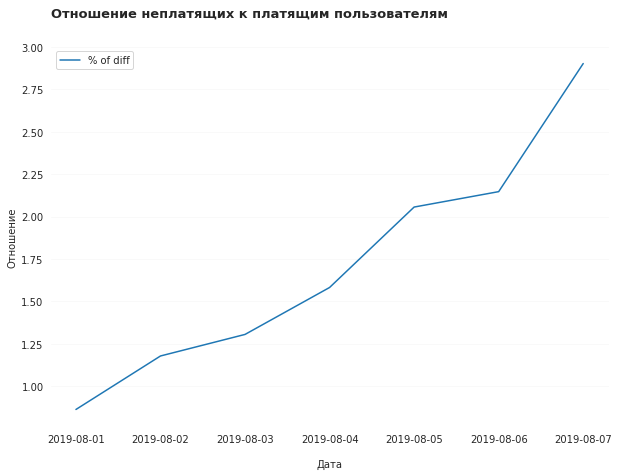

In [32]:
# Установим стиль whitegrid из seaborn
sns.set_style('whitegrid')

# Зададим размер
plt.figure(figsize=(10, 7))

#  Построим график
ax = plt.subplot(1, 1, 1)
payer_by_day[['date', '% of diff']].plot(x='date', y=['% of diff'], ax=ax)

# добавим легкие горизонтальные линии
plt.grid(axis='y', alpha=0.15)
plt.grid(axis='x', alpha=0)

# спрячем лишние границы
sns.despine(left=True, bottom=True)

# Подпишем график, оси
plt.xlabel('Дата', labelpad=15)
plt.ylabel('Отношение')
plt.title('Отношение неплатящих к платящим пользователям',
          loc='left', fontsize=13, fontweight='bold', pad=30)
plt.show();

Любопытно - с некоторой осторожностью можно зафиксировать снижение числа платящих, нарастание числа неплатящих. В отстутвие дополнительных данных, принимая во внимание короткий период - нет достаточных оснований для резюмирущих выводов, однако локально стоит обратить внимание на отношение не платящих к платящим.

&#9889; **Выводы**

1. Из 7 419 уникальных пользователей, 2 826 так и не перешли на экран с предложениями товара.
2. Только 46.97% (3 539) прошли от первого до последнего этапа.
3. Из 7 419 уникальных пользователей 2 826 (37%) так и не перешли с главной страницы - это шаг с наибольшей потерей. Кроме того, при переходе с экрана предложений 859 (18%) из 4593 перешедших на экран предложений пользователей не перешли к оформлению заказа. Только 195 (4%) из 3734 так и не оплатили товар. 
4. Следовательно, половина пользователей не доходят до корзины - установить причину исходя из данных не представляется возможным, требуются сведения об устройствах, каналах привлечения, способах оплаты и так далее.
5. Отмечаем в течение недели рост отношения в пользу неплатящих пользователей - в отсутвие данных без конкретных выводов: это повод для более широкого анализа на большем объеме данных.

[В оглавление](#TOC)

# IV. Анализ A/A/B-теста<a class='anchor' id='4'></a>

### - подготовимся к анализу

Создадим класс для статистических тестов, подготовим несколько полезных функций:

Инициализируем класс:

In [33]:
tests = StatTest(logs)

## 1) Проверим корректность разбиения групп<a class="anchor" id="4_1"></a>

### - проверим чиcло пользователей в каждой из групп

Используем ранее полученные профили пользователей:

In [34]:
profiles

,id,timestamp,first_ts,group,dt,month,last_event,payer
0,6888746892508752,2019-08-06 14:06:34,2019-08-06,A_one,2019-08-06,2019-08-01,main screen,False
1,6909561520679493,2019-08-06 18:52:54,2019-08-06,A_two,2019-08-06,2019-08-01,payment,True
2,6922444491712477,2019-08-04 14:19:33,2019-08-04,A_one,2019-08-04,2019-08-01,payment,True
3,7435777799948366,2019-08-05 08:06:34,2019-08-05,B_test,2019-08-05,2019-08-01,main screen,False
4,7702139951469979,2019-08-01 04:29:54,2019-08-01,A_two,2019-08-01,2019-08-01,payment,True
...,...,...,...,...,...,...,...,...
7529,9217594193087726423,2019-08-02 09:00:57,2019-08-02,A_one,2019-08-02,2019-08-01,payment,True
7530,9219463515465815368,2019-08-05 05:26:26,2019-08-05,B_test,2019-08-05,2019-08-01,payment,True
7531,9220879493065341500,2019-08-02 17:58:48,2019-08-02,A_one,2019-08-02,2019-08-01,offer screen,False
7532,9221926045299980007,2019-08-01 17:30:27,2019-08-01,A_one,2019-08-01,2019-08-01,main screen,False


Посчитаем пользователей по группам:

In [35]:
simple_grouper(profiles, 'group')

,group,id,percent
2,B_test,2537,33.67
1,A_two,2513,33.36
0,A_one,2484,32.97


Все три группы примерно одного размера, разница между группами не превышает 1%.

### - проверим пересечения между группами

In [36]:
intersection = get_intersections(logs, groups=['A_one', 'A_two'], test_group=['B_test'])

Пересечений нет, группы изолированы.


&#9889; **Выводы**

1. Всего в таблице три группы - две контрольных, одна тестовая: 
    - 2537 (33.67% от общего числа уникальных пользователей),
    - 2513 (33.36% от общего числа уникальных пользователей),
    - 2484 (32.97% от общего числа уникальных пользователей).
2. Все три группы примерно одного размера, разница между группами не превышает 1%.
3. Пересечений между группами нет.

[В оглавление](#TOC)

## 2) Проведем статистические тесты для контрольных групп<a class="anchor" id="4_2"></a>

### - убедимся, что полученная выборка распределена нормально

Проверим гипотезу о том, что данные получены из генеральной совокупности с нормальным распределением, для чего воспользуемся критерием Шапиро-Уилка.

1. Нулевую гипотезу, которую проверяет тест, сформулируем так: "Выборка  нормально распределена",
2. Альтернативную гипотезу, соответственно, сформулируем так: "Распределение выборки не нормально",
3. Примем уровень значимости в 5%.

Подготовим параметры для теста:

In [37]:
params_of_test = {'sample_name': 'Полная выборка',
                  'alpha': 0.05,
                  'zero_hypothesis': 'Выборка нормально распределена',
                  'alt_hypothesis': 'Распределение выборки не нормально',
                  'test': 'shapiro'}

Проведем тест:

In [38]:
tests.test_designer(params_of_test)
report_styler(tests.result)

,Выборка,Нулевая гипотеза (Н0),Альтернативная гипотеза (Н1),alpha,p-value,p-value < alpha,Н0/Н1
0,Полная выборка,Выборка нормально распределена,Распределение выборки не нормально,0.05,0.111245,False,Н0


&#9889; **Выводы**

В отношении распределения выборки, исходя из представленных данных, на уровне значимости 5% - нет оснований отвергнуть нулевую гипотезу в пользу альтернативы: выборка нормально распределена.

[В оглавление](#TOC)

### - проведем статистические тесты в отношении контрольных групп

Исходя из результов применения к выборке критерия Шапиро-Уилка на уровне значимости 5% - выборка нормально распределена. Поскольку, принимая во внимаение задачу, нужно проверить повлиял ли новый шрифт на поведение пользователей (безотносительно того как именно повлиял) - нас интересует изменилась ли пропорция пользователей от типичных события к событию в тестовой группе. Учитывая, что получена относительно большая выборка, мы можем применить Z-тест для проверки гипотезы о равенстве долей в группах.

Для начала применим Z-тест к контрольным группам, чтобы убедиться в корректности разделения групп.

Проверим гипотезу о том, что доли пользователей в двух контрольных группах одинаковы на кждом из шагов.

1. Нулевую гипотезу, которую проверяет тест, сформулируем так: "Между долями пользователей в контрольных группах нет статистически значимой разницы",
2. Альтернативную гипотезу, соответственно, сформулируем так: "Между долями пользователей в контрольных группах есть статистически значимая разница",
3. Примем уровень значимости в 5%.

Подготовим параметры для теста:

In [39]:
sample_name = 'Контрольные группы'
params_of_test = {'sample_name': sample_name,
                  'alpha': 0.05,
                  'zero_hypothesis': 'Между долями пользователей нет различий',
                  'alt_hypothesis': 'Между долями пользователей есть различия',
                  'test': 'z_test'}

Проведем тест и выведем результат:

In [40]:
tests.test_routine(params_of_test, groups_labels=[['A_one'], ['A_two']],
                   sample_name=sample_name)

Выведем результат:

In [41]:
report_styler(tests.result)

,Выборка,Нулевая гипотеза (Н0),Альтернативная гипотеза (Н1),alpha,p-value,p-value < alpha,Н0/Н1
0,Контрольные группы: main screen,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.757060,False,Н0
1,Контрольные группы: offer screen,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.248095,False,Н0
2,Контрольные группы: cart,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.228834,False,Н0
3,Контрольные группы: payment,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.114567,False,Н0


&#9889; **Выводы**

1. В отношении различий долей между двумя контрольными группами, исходя из представленных данных, на уровне значимости 5% - нет оснований отвергнуть нулевую гипотезу в пользу альтернативы: между долями пользователей в контрольных группах нет статистически значимой разницы.
2. Принимая во внимание, что разница в количестве пользователей между контрольными группами не превышает 1%, между группами нет пересечений, учитывая результаты статистического теста - с некоторой осторожностью, можно утверждать, что группы разеделены корректно.

[В оглавление](#TOC)

## 3) Проведем статистические тесты для тестовой группы<a class="anchor" id="4_3"></a>

### - проведем статистические тесты в отношении контрольной группы А-1 и тестовой группы В

Проверим гипотезу о том, что доли пользователей в группе А-1 и группе В одинаковы на каждом из шагов.

1. Нулевую гипотезу, которую проверяет тест, сформулируем так: "Между долями пользователей в группах нет статистически значимой разницы",
2. Альтернативную гипотезу, соответственно, сформулируем так: "Между долями пользователей в группах есть статистически значимая разница",
3. Примем уровень значимости в 5%.

Подготовим параметры для теста:

In [42]:
sample_name = 'Группа А-1 и тестовая В'
params_of_test = {'sample_name': sample_name,
                  'alpha': 0.05,
                  'zero_hypothesis': 'Между долями пользователей нет различий',
                  'alt_hypothesis': 'Между долями пользователей есть различия',
                  'test': 'z_test'}

Проведем тест и выведем результат:

In [43]:
tests.test_routine(params_of_test, groups_labels=[['A_one'], ['B_test']],
                   sample_name=sample_name)

Выведем результат:

In [44]:
report_styler(tests.result[tests.result['Выборка'].str.startswith('Группа А-1')])

,Выборка,Нулевая гипотеза (Н0),Альтернативная гипотеза (Н1),alpha,p-value,p-value < alpha,Н0/Н1
4,Группа А-1 и тестовая В: main screen,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.294972,False,Н0
5,Группа А-1 и тестовая В: offer screen,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.208362,False,Н0
6,Группа А-1 и тестовая В: cart,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.078429,False,Н0
7,Группа А-1 и тестовая В: payment,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.212255,False,Н0


&#9889; **Выводы**

В отношении различий долей между контрольной группой А-1 и тестовой группой В, исходя из представленных данных, на уровне значимости 5% - нет оснований отвергнуть нулевую гипотезу в пользу альтернативы: между долями пользователей в группе А-1 и тестовой группе В нет статистически значимой разницы.

[В оглавление](#TOC)

### - проведем статистические тесты в отношении контрольной группы А-2 и тестовой группы В

Проверим гипотезу о том, что доли пользователей в группе А-2 и группе В одинаковы на каждом из шагов.

1. Нулевую гипотезу, которую проверяет тест, сформулируем так: "Между долями пользователей в группах нет статистически значимой разницы",
2. Альтернативную гипотезу, соответственно, сформулируем так: "Между долями пользователей в группах есть статистически значимая разница",
3. Примем уровень значимости в 5%.

Подготовим параметры для теста:

In [45]:
sample_name = 'Группа А-2 и тестовая В'
params_of_test = {'sample_name': sample_name,
                  'alpha': 0.05,
                  'zero_hypothesis': 'Между долями пользователей нет различий',
                  'alt_hypothesis': 'Между долями пользователей есть различия',
                  'test': 'z_test'}

Проведем тест:

In [46]:
tests.test_routine(params_of_test, groups_labels=[['A_two'], ['B_test']], sample_name=sample_name)

Выведем результат:

In [47]:
report_styler(tests.result[tests.result['Выборка'].str.startswith('Группа А-2')])

,Выборка,Нулевая гипотеза (Н0),Альтернативная гипотеза (Н1),alpha,p-value,p-value < alpha,Н0/Н1
8,Группа А-2 и тестовая В: main screen,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.458705,False,Н0
9,Группа А-2 и тестовая В: offer screen,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.919782,False,Н0
10,Группа А-2 и тестовая В: cart,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.578620,False,Н0
11,Группа А-2 и тестовая В: payment,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.737342,False,Н0


&#9889; **Выводы**

В отношении различий долей между контрольной группой А-2 и тестовой группой В, исходя из представленных данных, на уровне значимости 5% - нет оснований отвергнуть нулевую гипотезу в пользу альтернативы: между долями пользователей в группе А-2 и тестовой группе В нет статистически значимой разницы.

[В оглавление](#TOC)

### - проведем статистические тесты в отношении объединенных контрольных групп и тестовой группы В

Проверим гипотезу о том, что доли пользователей в контрольных группах и группе В одинаковы на каждом из шагов.

1. Нулевую гипотезу, которую проверяет тест, сформулируем так: "Между долями пользователей в группах нет статистически значимой разницы",
2. Альтернативную гипотезу, соответственно, сформулируем так: "Между долями пользователей в группах есть статистически значимая разница",
3. Примем уровень значимости в 5%.

Подготовим параметры для теста:

In [48]:
sample_name = 'Объединенные А и тестовая В'
params_of_test = {'sample_name': sample_name,
                  'alpha': 0.05,
                  'zero_hypothesis': 'Между долями пользователей нет различий',
                  'alt_hypothesis': 'Между долями пользователей есть различия',
                  'test': 'z_test'}

In [49]:
tests.test_routine(params_of_test, groups_labels=[['A_one', 'A_two'], ['B_test']],
                   sample_name=sample_name, united=True)

In [50]:
report_styler(tests.result[tests.result['Выборка'].str.startswith('Объединенные')])

,Выборка,Нулевая гипотеза (Н0),Альтернативная гипотеза (Н1),alpha,p-value,p-value < alpha,Н0/Н1
12,Объединенные А и тестовая В: main screen,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.294245,False,Н0
13,Объединенные А и тестовая В: offer screen,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.434255,False,Н0
14,Объединенные А и тестовая В: cart,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.181759,False,Н0
15,Объединенные А и тестовая В: payment,Между долями пользователей нет различий,Между долями пользователей есть различия,0.05,0.600429,False,Н0


&#9889; **Выводы**

В отношении различий долей между объединненными контрольными группами и тестовой группой В, исходя из представленных данных, на уровне значимости 5% - нет оснований отвергнуть нулевую гипотезу в пользу альтернативы: между долями пользователей в контрольных группах и тестовой группе В нет статистически значимой разницы.

[В оглавление](#TOC)

### - комментарий по уровню значимости

Было проведено шестнадцать тестов на одних и тех же данных, что должно повышать требования к уровню значимости. В каждом тесте использован уровень значимости - 5%. Можно было бы использовать поправку Бонферрони:

In [51]:
alpha = 0.05
bonferroni_alpha = alpha / 16
bonferroni_alpha

0.003125

С поправкой уровень значимости должен быть установлен на уровне 0.3%. Проверим самое низкое p-value в результатах:

In [52]:
tests.result['p-value'].min()

0.07842923237520125

Принимая во внимание, что самое низкое p-value равно 0.07 поправка уровня значимости лишена практического смысла.

[В оглавление](#TOC)

# Выводы<a class='anchor' id='conclusions'></a>

1. В представленных данных 244126 наблюдений за две недели: от 25 июля 2019 года до 07.08.2019 года. Данные идут последовательно, без явных пропусков, без явных проблем с типом данных.
2. Выявлено, что за период от 25.07.2019 года до 31.07.2019 года зафиксировано чуть более 1% всех наблюдений о пользователях (2 826).
3. После исключения полных дубликатов (413 наблюдений) и неполных данных за период от 25.07.2019 года до 31.07.2019 года – получили таблицу с 240 887 строками и 6 колонками, без пропусков и проблем с данными. 
4. Дополнительно переименовали группы и события для улучшения восприятия. Группы 246 – А_one (A-1), 247 – A_two (A-2), 248 – B_test.
5. Всего в датасете представлено пять событий (с учетом переименования):
    - main screen (посетило 7 439 уникальных пользователей из 7 551, 98.47%)
    - offer screen (посетило 4613 уникальных пользователей из 7 551, 60.96%)
    - cart (посетило 3749 уникальных пользователей из 7 551, 49.56%)
    - payment (посетило 3547 уникальных пользователей из 7 551, 46.97%)
    - tutorial (посетило 847 уникальных пользователей из 7 551, 11.15%)
    - В среднем, на пользователя приходится 32.27 событий
7. Опираясь на число и долю пользователей и повременное появление событий в таблице с некоторой осторожностью, можно утверждать, что посетители интернет-магазина до оплаты товара проходят такие шаги:
    - Попадают на экран с обучением,
    - Заходят на главную страницу магазина.
    - Переходят на страницу товара.
    - Добавляют товар в корзину.
    - Переходят в корзину, оформляют заказ.
    - Оплачивают заказ.
8. Учитывая, что обучение проходят всего 11.15% уникальных пользователей и, разумно предположить, обучение не загружается каждый раз, этот шаг является необязательной частью взаимодействия с магазином. Как следствие шаг исключен при дальнейшем анализе.
9. Только 46.97% (3 539) пользователей прошли от первого до последнего этапа.
10. Из 7 419 уникальных пользователей 2 826 (37%) так и не перешли с главной страницы - это шаг с наибольшей потерей. Кроме того, при переходе с экрана предложений 859 (18%) из 4593 перешедших на экран предложений пользователей не перешли к оформлению заказа. Только 195 (4%) из 3734 так и не оплатили товар.
11. Установить причину потери пользователей на каждом из шагов с разумной степенью достоверности исходя из данных не представляется возможным.
12. Всего в таблице три группы - две контрольных, одна тестовая:
    - 2537 (33.67% от общего числа уникальных пользователей),
    - 2513 (33.36% от общего числа уникальных пользователей),
    - 2484 (32.97% от общего числа уникальных пользователей).
13. К данным был применен Z-тест для проверки гипотезы о равенстве долей в группах.
14. Разделение групп было произведено корректно: разница в количестве пользователей менее одного процента, статистически значимых различий между контрольными группами не выявлено.
15. По результатам статистического теста в отношении контрольных и тестовой группы, на уровне значимости 5%, не удалось опровергнуть гипотезу о равенстве долей пользователей на каждом шаге. Как следствие, следует сделать вывод о том, что изменение шрифта не повлияло на пользователей с точки зрения конверсии.


[В оглавление](#TOC)